In [1]:
import rasterio
import glob
import os,sys
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
# import geopandas as gpd
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

%matplotlib inline

In [2]:
# import the helper functions
from test_unet_helpers import *


In [3]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../../rasters/union_impervious_raster_2_0_0.tif' # desktop
gt_image_2 = '../../rasters/union_impervious_raster_2_0_0_wgs84.tif' # desktop
# gt_image_2 = '../rasters/union_impervious_raster_2_0_0.tif' # laptop
#gt_image_2 = 'C:/projects/smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_2_0.tif'

# specify images for 0.5 meter analysis
gt_image_05 = '../../rasters/union_impervious_raster_0_5.tif' # desktop
# gt_image_05 = '../rasters/union_impervious_raster_0_5.tif' # laptop
#gt_image_05 = 'C:/projects/smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif'

# specify the shapefile
# shpfile = '../Denver_Sample_Sites/union/union_grid_index256.shp'
shpfile = '../../union/union.shp' # desktop
# shpfile = '../union/union.shp' # desktop
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
#     for s in shp:
#         # rows.append(shape(s['geometry']))
#         pass
        
        
    shp_bounds = shp.bounds


In [ ]:
img_utm = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True, epsg='32613')


In [ ]:
img_utm.shape, img_2m.shape, 

Sample Points

1) random sample row and column in GBDX image 
* get lon / lat from Affine object
* sample from rasterio object
 - get row / column from Ground Truth image, create window
 - if window is not NaN, then get it and save both

In [4]:
from gbdxtools import Interface, CatalogImage

# connect to gbdx
gbdx = Interface()

# get the dask array for the 8 band MS image
img_2m = CatalogImage(dg_scene_id, band_type='MS', bbox=shp_bounds, acomp=True)
rows, cols = img_2m.shape[1:]

# get the dask array for the Pansharpened, 4 band image
image_05m = CatalogImage(dg_scene_id, bbox=shp_bounds, acomp=True, pansharpen=True)
rowsP, colsP = image_05m.shape[1:]
pan_factorR = np.floor(rowsP/rows)
pan_factorC = np.floor(colsP/cols)

In [5]:
image_05m.shape, img_2m.shape, os.path.exists(gt_image_2)

((8, 9409, 12924), (8, 2352, 3231), True)

In [6]:
# generate the sample points
# we have some funny stuff from ArcGIS converting the polygons to a raster... so... 
# generate the points within the bounds of the shapefile / DG image array

import random

random.seed(101)

num = 10000
side = 64
coords = []
coords_pan = []
im_patches = []
im_patches_pan = []

with rasterio.open(gt_image_2, 'r') as src:
    
    for i in range(num):
        ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols) 

        try:
            r_start = ran_row - side/2
            r_end = ran_row + side/2
            c_start = ran_col - side/2
            c_end = ran_col + side/2
            #im_data = img_2m[:, r_start:r_end, c_start:c_end]

            pr_start = ran_row*pan_factorR - side/2
            pr_end = ran_row*pan_factorR + side/2
            pc_start = ran_col*pan_factorC - side/2
            pc_end = ran_col*pan_factorC + side/2
            #im_data_pan = image_05m[:, pr_start:pr_end, pc_start:pc_end]

            # append regardless and check later.

            #############################################################################################################
            ### SHOULD CHECK THE INFORMATION THRESHOLDS BELOW, BUT HERE, TO RESELECT ROWS AND COLUMNS UNTIL IT IS MET ###
            #############################################################################################################

            s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
            pt_flag = checkWindow(src, s_pt)
            while pt_flag:
                ran_row, ran_col = random.randrange(0,rows), random.randrange(0,cols)
                s_pt = calcXYfromRC(img_2m.affine, (ran_row, ran_col))
                pt_flag = checkWindow(src, s_pt)

            coords.append((ran_row, ran_col))
            coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))

            # check for nan
    #         if np.isnan(im_data.mean().compute()):
    #             print(i,im_data)
    #         else:
    #             coords.append((ran_row, ran_col))
    #             coords_pan.append(( int(ran_row*pan_factorR), int(ran_col*pan_factorC)))
    #             #im_patches.append(im_data)
    #             #im_patches_pan.append(im_data_pan)
        except Exception as e:
            print(e)
    #         print('{}, out of bounds'.format(i))
    #         print(r_start, r_end, c_start, c_end)

    coords_arr = np.array(coords)  

In [ ]:
rasterio.__version__

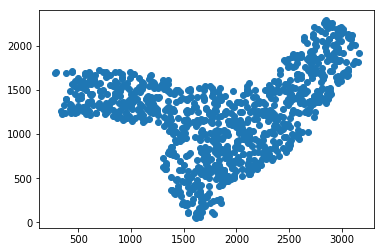

In [7]:
plt.scatter(coords_arr[:,1], coords_arr[:,0])

In [ ]:
lonlat_MS = [calcXYfromRC(img_2m.affine, pair) for pair in coords]
lonlat_PAN = [calcXYfromRC(image_05m.affine, pair) for pair in coords_pan]

In [ ]:
lonlat_MS[0]
        

In [ ]:
import pyproj
       
def assignRC2(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    outProj = Proj(init=outproj)
    inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x2,y2)
    r,c = [int(c) for c in temp]
    
    return ((x3,y3), samp_pt, r,c)

def assignRC3(rio_obj, samp_pt, window_size=64, inproj='epsg:4326', outproj='epsg:32613'):
    # project the point to source crs
    #outProj = Proj(init=outproj)
    #inProj = Proj(init=inproj)
    x1,y1 = samp_pt        
    #x2,y2 = pyproj.transform(inProj, outProj ,x1,y1)
    #x3,y3 = pyproj.transform(outProj, inProj, x2,y2)
    
    # get the row column
    temp = rio_obj.index(x1,y1)
    r,c = [int(c) for c in temp]
    
    return ((x1,y1), samp_pt, r,c)

# use the lonlats_* lists to sample the ground truth image. return the histogram if the window is on the border,
# which should be evident if the window extends across
with rasterio.open(gt_image_2, 'r') as src:
    #print(src.crs)

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_MS = [assignRC3(src, samp_pt) for samp_pt in lonlat_MS]

# do the same for the 0.5 meter ground truth raster
with rasterio.open(gt_image_05, 'r') as src:

    # cull the lon/lat points by checking if they include nodata pixels
    gt_pts_PAN = [assignRC(src, samp_pt) for samp_pt in lonlat_MS]




In [ ]:
gt_pts_MS[1]

In [ ]:
## view on map
from shapely.ops import transform
from shapely.geometry import shape, Point

geoms = [Point(pair).buffer(0.00001).__geo_interface__ for pair in lonlat_MS]
    
geojson = {"type": "FetureCollection", "features": []}
for idx, geom in enumerate(geoms):
    g = {
        "type": "Feature",
        "geometry": geom,
        "properties": {"id": idx+1}
    }
    geojson['features'].append(g)
    

print(geojson['features'][0].keys())
# gbdx.vectors.map(features=geojson['features'], zoom=11)
style= {
                        "line-color": '#ff0000',
                        "line-opacity": .99,
                        "line-width": 4
                    }

mapbox_api_key = 'pk.eyJ1Ijoiam9lbWNnY3UiLCJhIjoiY2pla2I1Z2FiMHo2cDJ3bjVwMnJuZWloNiJ9.otjTJOYusw-XYsUohs7ZGg'
gbdx.vectors.map(features=geojson['features'], style=style, zoom=11, api_key=mapbox_api_key)


              

            

## now there are points to generate training samples. Load some classes that will sample the images and return the training arrays.


In [ ]:
rand_inds = random.sample(range(10000),30)

for sample_ind in rand_inds:
    print('\n\nSample ID: {}'.format(sample_ind))
    # check the images
    gt_2m_rowcol = [x[2:] for x in gt_pts_MS]
    gt_dataset = gtDatasetSampler(gt_image_2, gt_2m_rowcol) # 64 pixel dimension windows
    # gt_dataset = gtDatasetSampler(gt_image_2, gt_pts_PAN) # 64 pixel dimension windows
    sample_gt = gt_dataset[sample_ind]
    print(sample_gt.shape)
    #plt.imshow(sample_gt)
    #plt.colorbar()
    #plt.show()

    dg_dataset = DigitalGlobeSampler(img_2m, coords)
    # dg_dataset = DigitalGlobeSampler(img_pan)
    sample = np.rollaxis(dg_dataset[sample_ind],0,3)
    print(sample.shape)
    #plt.imshow(misc.bytescale(sample[:,:,[4,3,1]]))
    #plt.show()
    
    plt.imshow(misc.bytescale(sample[:,:,[4,3,1]]))
    plt.imshow(sample_gt, alpha = 0.15)
    plt.show()
    

    # see that they are the same size


In [ ]:
gt_pts_MS[8763], float(img_utm.ipe_metadata['image']['groundSampleDistanceMeters'])/2

In [ ]:
f

### main chipping code.. first ground truth, then DG